## Finding the changepoint in data

Given some organized set of 1D data, the aim is to find out at which point occured a change in its distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Getting repeatable results
REPEATABLE = True # Change to False if needed

seed = None
if REPEATABLE:
    seed = 12345
    tf.random.set_seed(seed)
    np.random.seed(seed)

#### Preparing the data

Let us assume that there are 100 samples and we draw them from two Poisson distributions of different lambdas. Moreover there is a specific switchpoint separating those samples, yet most likely not quite apparrent when looking at the drawn data.

In [3]:
# User defined parameters
switchpoint = 64 # important: switchpoint index! (x in [0, 99])
lambda1_real = 5.3
lambda2_real = 4.1

# Distribution before the switchpoint
draw_distribution_1 = tfd.Poisson(
    rate = tf.constant(lambda1_real, dtype=float)
)
# Distribution after the switchpoint (inclusive)
draw_distribution_2 = tfd.Poisson(
    rate = tf.constant(lambda2_real, dtype=float)
)

In [4]:
before_switchpoint = draw_distribution_1.sample(
    sample_shape = tf.constant(switchpoint, dtype=tf.int32),
    seed = seed
)

after_switchpoint = draw_distribution_2.sample(
    sample_shape = tf.constant(100 - switchpoint, dtype=tf.int32),
    seed = seed
)

data = tf.concat([before_switchpoint, after_switchpoint], axis = 0)

In [5]:
data

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 8.,  3.,  8.,  3.,  4.,  9.,  5., 11.,  8.,  4.,  7.,  8.,  6.,
        4.,  8.,  2.,  3.,  5.,  5., 13.,  9.,  6.,  2.,  7.,  7.,  4.,
        9.,  5.,  2.,  4.,  8.,  4.,  8.,  3.,  5.,  5.,  0.,  3.,  9.,
        8.,  1.,  4.,  5.,  4.,  4.,  3.,  5.,  5.,  5.,  4., 16.,  6.,
        9.,  3.,  8.,  6.,  5.,  4.,  7.,  5.,  4.,  5.,  3.,  4.,  6.,
        1.,  3.,  3.,  3.,  5.,  1.,  4.,  2.,  5.,  2.,  2.,  5.,  6.,
        5.,  5.,  3.,  3.,  5.,  6.,  3.,  6.,  6.,  3.,  2.,  2.,  9.,
        6.,  3.,  6.,  5.,  4.,  2.,  0.,  5.,  4.], dtype=float32)>

<BarContainer object of 100 artists>

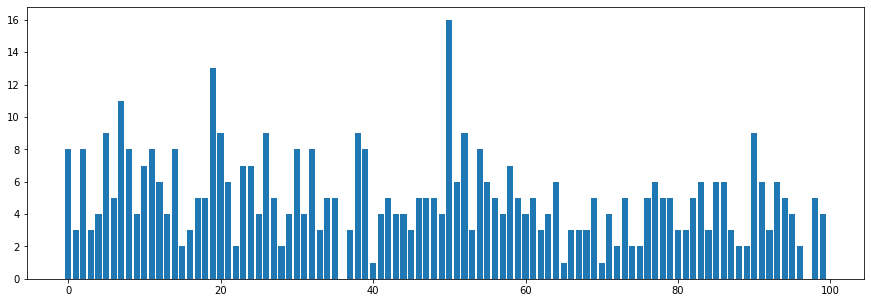

In [6]:
fig = plt.figure(figsize=(15,5))
plt.bar(np.arange(0,100), data)

#### Assumptions

* Let us denote the changepoint as **tau**.
* Every sample lefts to the tau (exclusively) is drawn from distribution `Poisson(rate=lambda1)`.
* Accordingly the remaining ones are drawn from distribution `Poisson(rate=lambda2)`.

Thus:

* We will use MCMC to find lambda1, lambda2 and tau.
* Lambdas are expected to be best suggested by the exponential distibution with rate (alpha).
* Tau is equally likely to be located in every part of the range, so it is wise to draw potential values of it from uniform distribution.

In [7]:
alpha = 1. / tf.reduce_mean(data)
lambda1_rv = tfd.Exponential(rate=alpha)
lambda2_rv = tfd.Exponential(rate=alpha)
tau_rv = tfd.Uniform()


def joint_log_prob(data, lambda_1, lambda_2, tau):
    lambdas = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(data)),
                         dtype=tf.float32), dtype=tf.int32)
    )
    rv_observation = tfd.Poisson(rate=lambdas)
    
    # Unnormalized Bayesian inference (log-scaled) posterior
    return (
         lambda1_rv.log_prob(lambda_1)
         + lambda2_rv.log_prob(lambda_2)
         + tau_rv.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(data))
    )

def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(data, lambda1, lambda2, tau)

In [8]:
def trace_everything(states, previous_kernel_results):
    return previous_kernel_results.inner_results

# Wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(num_results, num_burnin_steps, current_state, kernel):
    return tfp.mcmc.sample_chain(
        num_results = num_results,
        num_burnin_steps = num_burnin_steps,
        current_state = current_state,
        kernel = kernel,
        trace_fn = trace_everything
    )

n_burnin_steps = 5000
n_results = 20000

# Setting the chain's initial state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]

# Since HMC operates over unconstrained space, we need to transform the samples
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Mapping: R+ => R.
    tfp.bijectors.Exp(),       # Mapping: R+ => R.
    tfp.bijectors.Sigmoid(),   # Mapping: [0,1] => R.  
]

step_size = 0.2

kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalized_log_posterior,
        num_leapfrog_steps = 2,
        step_size = step_size,
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors
)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=int(n_burnin_steps * 0.8)
)

In [9]:
# Sample from the chain
[lambda_1_samples, lambda_2_samples, posterior_tau], kernel_results =\
    graph_sample_chain(
        num_results = n_results,
        num_burnin_steps = n_burnin_steps,
        current_state = initial_chain_state,
        kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(data), dtype=tf.float32))

In [10]:
print("Acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted,dtype=tf.float32))))

Acceptance rate: 0.6674500107765198


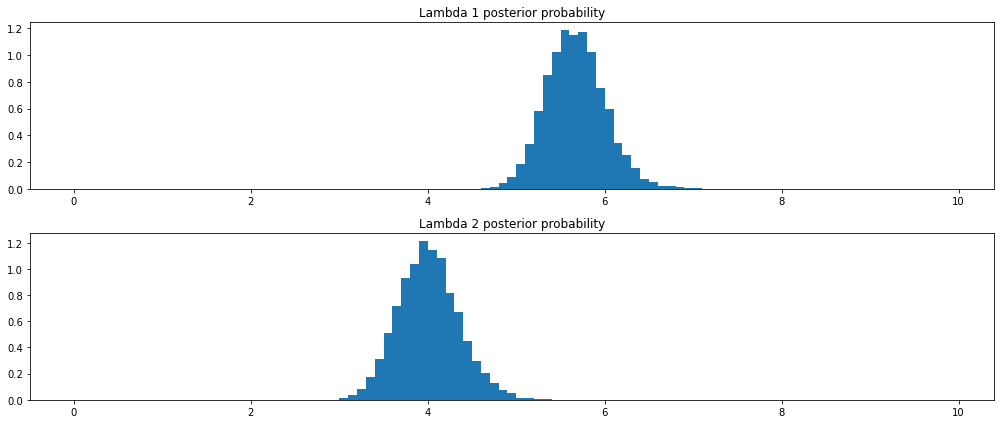

In [11]:
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(211)
ax1.hist(lambda_1_samples, bins=np.arange(0., 10., 0.1), density=True)
ax1.set_title("Lambda 1 posterior probability")

ax2 = plt.subplot(212)
ax2.hist(lambda_2_samples, bins=np.arange(0., 10., 0.1), density=True)
ax2.set_title("Lambda 2 posterior probability")

plt.tight_layout()
plt.show()

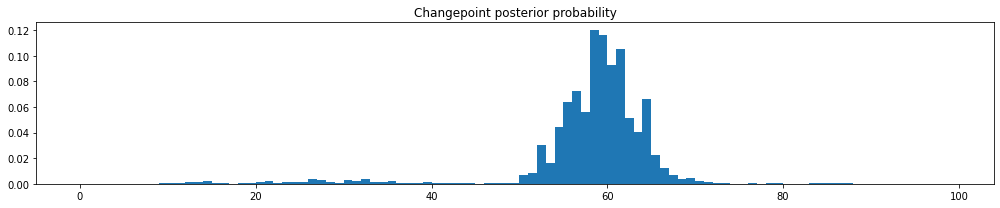

In [12]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot()

ax.set_title("Changepoint posterior probability")
ax.hist(tau_samples, bins=np.arange(0, 100, 1), density=True)
plt.tight_layout()
plt.show()

The results mostly comply with the real parameters from which the distribution has been drawn.